<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/pytorch/4_1_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load Data

In [2]:
file = "/content/gdrive/MyDrive/neural_data/TimeSeriesData/Energy_Production.csv"

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
df = pd.read_csv(file,index_col=0,parse_dates=True)
len(df)

325

In [6]:
df.head()

,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


In [7]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

## Plotting time series data

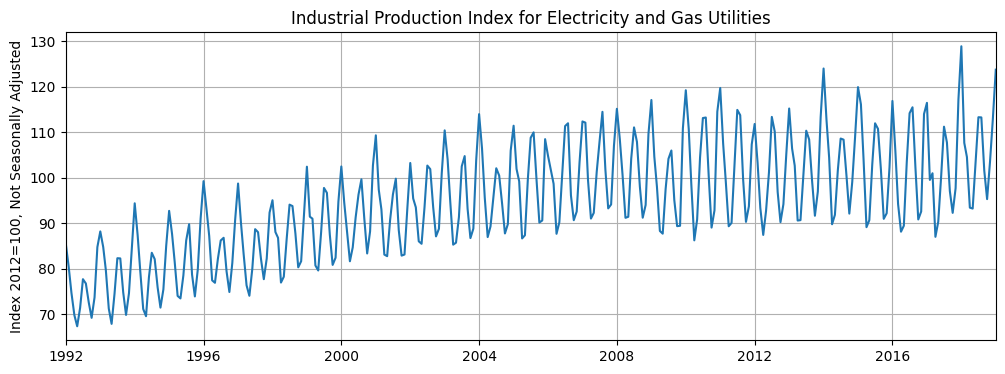

In [9]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

## Prepare the data

In [10]:
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


## Normalize the data

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 85.556
First item, scaled: [-0.4091274]


In [12]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM

In [14]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [15]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 301


## Define the model

In [16]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [17]:
torch.manual_seed(101)
model = LSTMnetwork()

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [19]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   256
 16384
   256
   256
    64
     1
______
 17217


## Train the model

In [20]:
epochs = 50

for i in range(epochs):
    for seq, y_train in train_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # OPTIONAL print statement
    print(f'{i+1} of {epochs} epochs completed')

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

## Run predictions and compare to known test test

In [21]:
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

preds[window_size:]

[0.25402793288230896,
 -0.0027752164751291275,
 -0.34294819831848145,
 -0.21167579293251038,
 0.23918864130973816,
 0.48914822936058044,
 0.2470800131559372,
 -0.08662212640047073,
 -0.25781774520874023,
 0.0225857961922884,
 0.5441879034042358,
 0.6110796928405762]

## Invert the normalization

In [23]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[105.95764234],
       [ 98.05722185],
       [ 87.59197015],
       [ 91.63050007],
       [105.50111896],
       [113.1910007 ],
       [105.74389306],
       [ 95.47771359],
       [ 90.21096598],
       [ 98.83744073],
       [114.88426875],
       [116.94216121]])

In [ ]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

## Plot the results

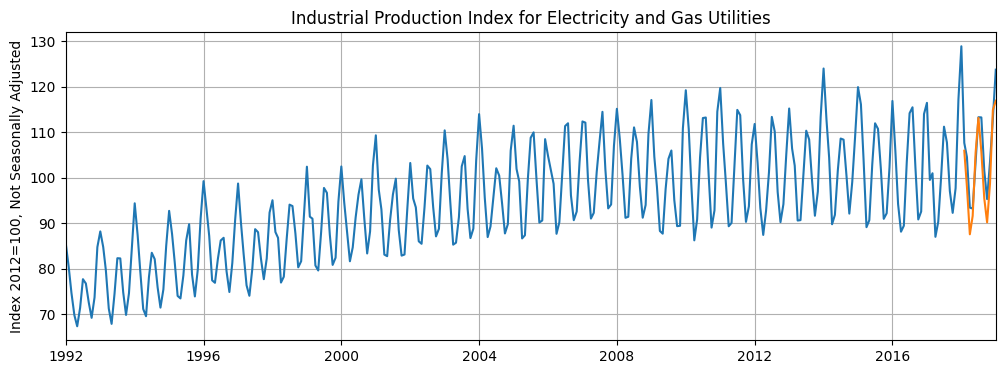

In [24]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

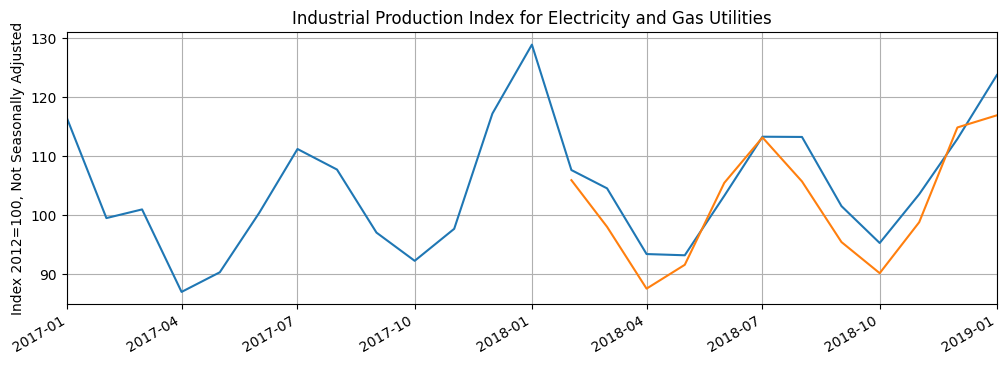

In [25]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()